In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from datetime import datetime

In [2]:
data = pd.read_csv('../data/data.csv')

In [55]:
data['trip_date'] = data['TRIP_ID'].astype('str') + data['CALENDAR_ID'].astype('str')

In [57]:
data["trip_date"].value_counts()

353036120230926    21
352966120230923    14
352272120230927    14
352287120230810    14
352900120230906    14
                   ..
353246120230918     2
353246120230911     2
353123120230911     2
352727120230911     2
353355120230815     1
Name: trip_date, Length: 67370, dtype: int64

In [4]:
trips = ''.join(data['TRIP_EDGE'].astype(str).tolist())
incomplete_trip_starts = [m.start() for m in re.finditer('20', trips)]

In [7]:
#Marks all trips whihc are complete (start with 1 and end with 2) as Complete_trip = True 
def mark_complete_trips():
    mydf = data.copy()
    mydf["Complete_trip"] = False
    trip_started = False
    for index, row in mydf.iterrows():
        trip_edge = row["TRIP_EDGE"]
        if trip_edge == 1:
            trip_started = True
            mydf.loc[index, "Complete_trip"] = True
        if trip_edge == 0 and trip_started:
          mydf.loc[index, "Complete_trip"] = True
        if trip_edge == 2 and trip_started:
          trip_started = False
          mydf.loc[index, "Complete_trip"] = True

    return mydf
        


In [10]:
data = mark_complete_trips()

In [85]:
data_complete_trips = data[data["Complete_trip"]==True]

In [97]:
data_complete_trips["TRIP_EDGE"].value_counts()

TRIP_EDGE
0    213869
1     67411
2     67411
Name: count, dtype: int64

In [87]:
# remove trips for which all trip edges don't have the same trip ID (there are only 4 such trips)
ones = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 1].index.to_list()
twos = data_complete_trips[data_complete_trips['TRIP_EDGE'] == 2].index.to_list()
not_same_tripids = []
for one, two in zip(ones, twos):
    if len(set(data_complete_trips.loc[one:two]["TRIP_ID"].tolist())) >1:
        not_same_tripids.append([one, two])
u = data_complete_trips.copy()
u["SAME_TRIP_IDs"] = True
for start, end in not_same_tripids:
    u.loc[start:end, 'SAME_TRIP_IDs'] = False
data_complete_trips = u[u['SAME_TRIP_IDs'] == True]
data_complete_trips = data_complete_trips.drop(columns=["SAME_TRIP_IDs", "Complete_trip"])
# data_complete_trips.to_csv('../data/data_complete_trips.csv')

In [98]:
start_adherences = data_complete_trips[data_complete_trips["TRIP_EDGE"] ==1]["ADHERENCE"]
end_adherences = data_complete_trips[data_complete_trips["TRIP_EDGE"] ==2]["ADHERENCE"]

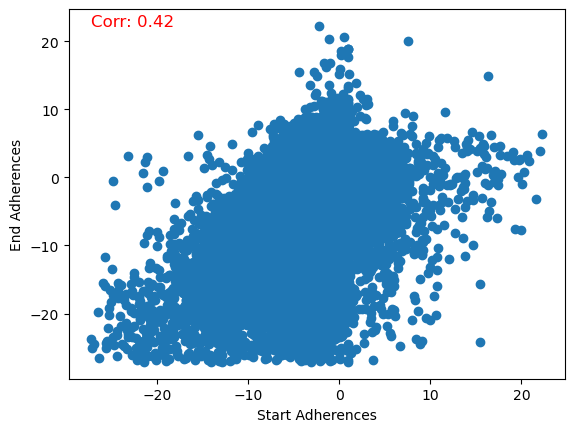

In [106]:
x_values = []
y_values = []
# lim = float('inf')
xmin = np.mean(start_adherences) - 3*np.std(start_adherences)
xmax = np.mean(start_adherences) + 3*np.std(start_adherences)
ymin = np.mean(end_adherences) - 3*np.std(end_adherences)
ymax = np.mean(end_adherences) + 3*np.std(end_adherences)
for x_value, y_value in zip(start_adherences, end_adherences):
    if not math.isnan(x_value) and not math.isnan(y_value) and xmin <= x_value < xmax and ymin <= y_value < ymax:
        x_values.append(x_value)
        y_values.append(y_value)
plt.scatter(x_values, y_values)
plt.xlabel("Start Adherences")
plt.ylabel("End Adherences")
correlation = np.corrcoef(x_values, y_values)[0, 1]
text_content = f"Corr: {correlation:.2f}"
textbox_x = min(x_values)  # X-coordinate for the top-left corner
textbox_y = max(y_values)  # Y-coordinate for the top-left corner (use the maximum y-value)
plt.text(textbox_x, textbox_y, text_content, fontsize=12, color='red')
plt.show()

In [97]:
data["PERC_HEADWAY_DEV"] = 100*data["HDWY_DEV"]/data["SCHEDULED_HDWY"]

In [108]:
u=data[["ADHERENCE", "SCHEDULED_HDWY", "HDWY_DEV"]].dropna()
u=u[u["SCHEDULED_HDWY"]>0]
u["PERC_HEADWAY_DEV"] = 100*u["HDWY_DEV"]/u["SCHEDULED_HDWY"]

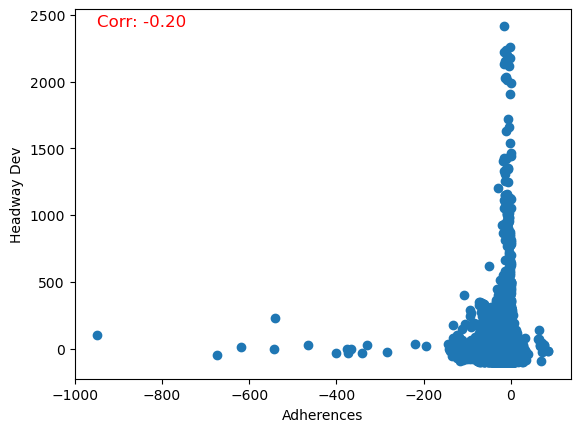

In [113]:
x_values = []
y_values = []
xvar = u["ADHERENCE"]
yvar = u["HDWY_DEV"]
xmin = np.mean(xvar) - 5*np.std(xvar)
xmax = np.mean(xvar) + 5*np.std(xvar)
ymin = np.mean(yvar) - 5*np.std(yvar)
ymax = np.mean(yvar) + 5*np.std(yvar)
for x_value, y_value in zip(u["ADHERENCE"], u["PERC_HEADWAY_DEV"]):
    # if not math.isnan(x_value) and not math.isnan(y_value) and xmin <= x_value < xmax and ymin <= y_value < ymax:
    if not math.isnan(x_value) and not math.isnan(y_value):
        x_values.append(x_value)
        y_values.append(y_value)
plt.scatter(x_values, y_values)
plt.xlabel("Adherences")
plt.ylabel("Headway Dev")
correlation = np.corrcoef(x_values, y_values)[0, 1]
text_content = f"Corr: {correlation:.2f}"
textbox_x = min(x_values)  # X-coordinate for the top-left corner
textbox_y = max(y_values)  # Y-coordinate for the top-left corner (use the maximum y-value)
plt.text(textbox_x, textbox_y, text_content, fontsize=12, color='red')
plt.show();

In [128]:
def time_difference_in_minutes(time_str1, time_str2):
    try:
        time_format = "%H:%M:%S"
        time1 = datetime.strptime(time_str1, time_format)
        time2 = datetime.strptime(time_str2, time_format)
        time_difference = time1 - time2
        minutes_difference = time_difference.total_seconds() / 60
        return minutes_difference
    except ValueError:
        # Handle invalid time string format
        return None

In [131]:
time_difference_in_minutes(data.iloc[0]["ACTUAL_ARRIVAL_TIME"],data.iloc[0]["ACTUAL_DEPARTURE_TIME"])

-6.5

In [66]:
data_complete_trips.head(10)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,Complete_trip
0,120230801,1,99457890,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,2,6.500000,True
1,120230801,1,99457891,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,9,0.000000,True
2,120230801,1,99457892,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,19,0.000000,True
3,120230801,1,99457893,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,NaN,0,35,0.000000,True
4,120230801,1,99457894,8/1/23,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,0.0,0,36,12.866666,True
5,120230801,1,99457895,8/1/23,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,0.0,0,51,0.000000,True
6,120230801,1,99457896,8/1/23,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,NaN,0,62,0.000000,True
7,120230801,1,99457897,8/1/23,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,True
8,120230801,1,99457898,8/1/23,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,True
9,120230801,1,99457899,8/1/23,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,True


In [100]:
start_adherences

0        -2.133333
4        -1.583333
7        -1.716666
11       -1.316666
14       -1.516666
            ...   
350313   -3.283333
350316   -0.850000
350319   -5.900000
350322   -8.616666
350325   -4.316666
Name: ADHERENCE, Length: 67411, dtype: float64

In [101]:
np.std(start_adherences)

8.51043667412849

In [115]:
data_complete_trips = data_complete_trips.drop(columns=["SAME_TRIP_IDs", "Complete_trip"])
data_complete_trips.to_csv('../data/data_complete_trips.csv')